Synced Dataset Size: 16153 rows
Preprocessing complete! Files saved to data/ folder.


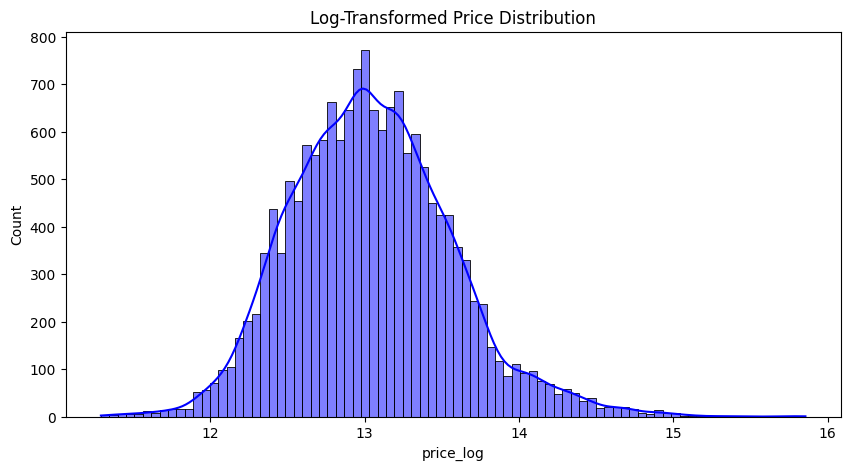

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. LOAD AND SYNC
# Load the raw Excel data
df = pd.read_excel("train(1).xlsx")

# Identify which images were successfully downloaded
image_folder = "house_images"
downloaded_ids = [int(f.split('.')[0]) for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Keep only rows that have a corresponding image
df_clean = df[df['id'].isin(downloaded_ids)].copy()
print(f"Synced Dataset Size: {len(df_clean)} rows")

# 2. DATA CLEANING
# Remove the famous '33 bedroom' outlier (data entry error)
df_clean = df_clean[df_clean['bedrooms'] < 30]

# Remove houses with 0 bedrooms or bathrooms to keep data logical
df_clean = df_clean[(df_clean['bedrooms'] > 0) & (df_clean['bathrooms'] > 0)]

# 3. FEATURE ENGINEERING (Tabular)
# Target Transformation: Use Log Price to normalize the distribution
df_clean['price_log'] = np.log1p(df_clean['price'])

# Select features for the model
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 
            'view', 'condition', 'grade', 'sqft_above', 'sqft_baseline', 'yr_built', 
            'lat', 'long']

# Handle missing columns (if any)
available_features = [f for f in features if f in df_clean.columns]
X_tabular = df_clean[available_features]
y = df_clean['price_log']

# 4. SCALING
# Scale features so sqft (thousands) and bedrooms (units) are comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tabular)

# Convert back to a DataFrame for easy saving
X_scaled_df = pd.DataFrame(X_scaled, columns=available_features)
X_scaled_df['id'] = df_clean['id'].values
X_scaled_df['price_log'] = y.values

# 5. SPLIT DATA
# Split into Train and Test (80/20)
train_df, test_df = train_test_split(X_scaled_df, test_size=0.2, random_state=42)

# 6. SAVE PROCESSED DATA
train_df.to_csv("data/processed_train.csv", index=False)
test_df.to_csv("data/processed_test.csv", index=False)
print("Preprocessing complete! Files saved to data/ folder.")

# 7. QUICK VISUAL CHECK
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['price_log'], kde=True, color='blue')
plt.title("Log-Transformed Price Distribution")
plt.show()

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
import numpy as np

class MultimodalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        # Handle both string paths and DataFrames
        self.data = pd.read_csv(csv_file) if isinstance(csv_file, str) else csv_file
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tab_features = torch.tensor(row.drop(['id', 'price_log'], errors='ignore').values, dtype=torch.float32)
        label = torch.tensor(row['price_log'], dtype=torch.float32)
        
        img_path = os.path.join(self.img_dir, f"{int(row['id'])}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, tab_features, label

image_transforms = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
import torch.nn as nn
from torchvision import models

class PricePredictor(nn.Module):
    def __init__(self, num_tabular_cols):
        super(PricePredictor, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')
        
        # UNFREEZE: Allow the CNN to learn from your images
        for param in self.resnet.parameters():
            param.requires_grad = True
            
        self.vision_features = nn.Sequential(*list(self.resnet.children())[:-1])
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_tabular_cols, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.regressor = nn.Sequential(
            nn.Linear(512 + 16, 64),
            nn.ReLU(),
            nn.Linear(64, 1) 
        )

    def forward(self, img, tab):
        v_feat = self.vision_features(img).view(img.size(0), -1)
        t_feat = self.tabular_branch(tab)
        combined = torch.cat((v_feat, t_feat), dim=1)
        return self.regressor(combined)

In [16]:
# Create DataLoaders
train_dataset = MultimodalDataset('data/processed_train.csv', 'house_images', image_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Initialize Model
num_features = pd.read_csv('data/processed_train.csv').shape[1] - 2
model = PricePredictor(num_tabular_cols=num_features)

# Setup Training Math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Ready to train on {device}!")

Ready to train on cpu!


In [17]:
from tqdm import tqdm
epochs = 5 

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for images, tabular, labels in loop:
        images, tabular, labels = images.to(device), tabular.to(device), labels.to(device).view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(images, tabular)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    print(f"Epoch {epoch+1} finished. Avg Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/5: 100%|██████████| 807/807 [06:37<00:00,  2.03it/s, loss=0.0297]


Epoch 1 finished. Avg Loss: 1.5473


Epoch 2/5: 100%|██████████| 807/807 [27:14<00:00,  2.03s/it, loss=0.0307]  


Epoch 2 finished. Avg Loss: 0.0647


Epoch 3/5: 100%|██████████| 807/807 [04:56<00:00,  2.73it/s, loss=0.053]  


Epoch 3 finished. Avg Loss: 0.0551


Epoch 4/5: 100%|██████████| 807/807 [04:36<00:00,  2.92it/s, loss=0.142]  


Epoch 4 finished. Avg Loss: 0.0526


Epoch 5/5: 100%|██████████| 807/807 [04:16<00:00,  3.14it/s, loss=0.0498] 

Epoch 5 finished. Avg Loss: 0.0546


In [20]:
# 1. Create the test dataset
test_dataset = MultimodalDataset(
    csv_file='data/processed_test.csv', 
    img_dir='house_images', 
    transform=image_transforms
)

# 2. Create the test loader
# num_workers=0 is safer for CPU testing
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=0
)

print(f"Test loader ready with {len(test_loader)} batches.")

Test loader ready with 404 batches.


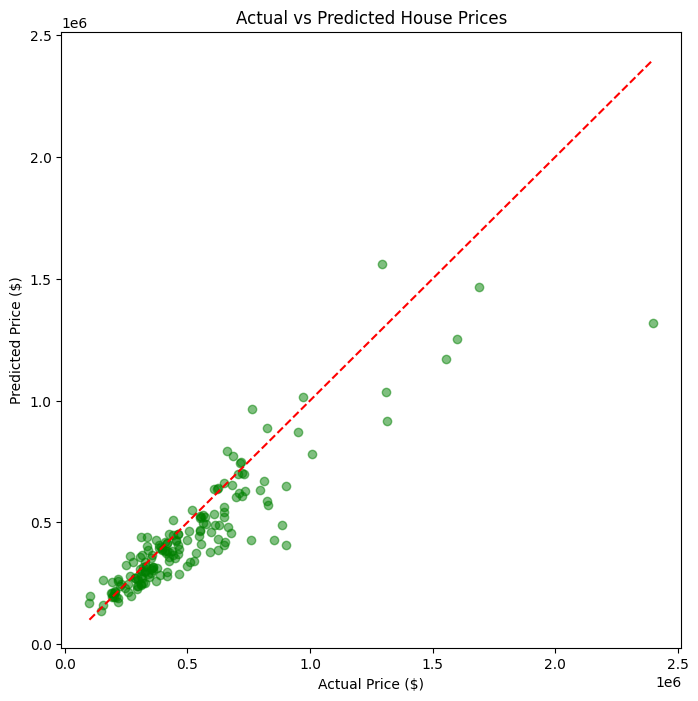

In [22]:
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_actuals = []

with torch.no_grad():
    # We use a small part of the test loader to keep it fast
    for i, (images, tabular, labels) in enumerate(test_loader):
        if i > 20: break # Only test on ~160 houses for a quick graph
        
        images, tabular = images.to(device), tabular.to(device)
        outputs = model(images, tabular)
        
        # Convert back from Log to Dollars
        all_preds.extend(np.expm1(outputs.cpu().numpy()).flatten())
        all_actuals.extend(np.expm1(labels.numpy()).flatten())

# Create the Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(all_actuals, all_preds, alpha=0.5, color='green')
plt.plot([min(all_actuals), max(all_actuals)], [min(all_actuals), max(all_actuals)], 'r--')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted House Prices")
plt.show()

In [23]:
from sklearn.metrics import r2_score

# Convert lists to numpy arrays
preds_array = np.array(all_preds)
actuals_array = np.array(all_actuals)

# Calculate R2 Score
score = r2_score(actuals_array, preds_array)
print(f"Final Model Accuracy (R2 Score): {score:.4f}")

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(preds_array - actuals_array))
print(f"Average Error: ${mae:,.2f}")

Final Model Accuracy (R2 Score): 0.7599
Average Error: $91,820.17


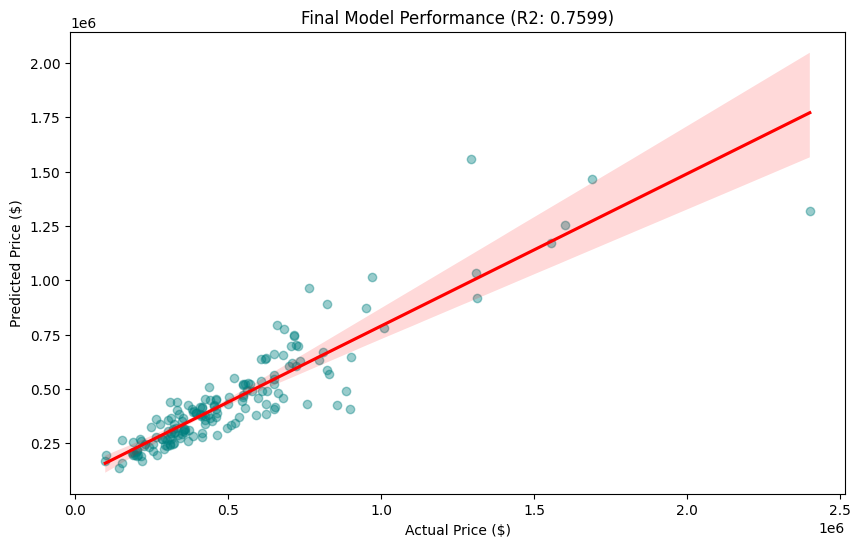

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(x=actuals_array, y=preds_array, scatter_kws={'alpha':0.4, 'color':'teal'}, line_kws={'color':'red'})
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title(f"Final Model Performance (R2: {score:.4f})")
plt.show()